# Who Survived the Titanic Disaster?

This workbook uses the titanic3 dataframe available at http://biostat.mc.vanderbilt.edu/twiki/pub/Main/DataSets/titanic.html to investigate basic techniques for applying supervised machine learning (ML) to classification. The task is to build a model that can predict whether a passenger survived (the outcome/target) based on features such as their age, gender, fare price, etc. 

In [1]:
import warnings
warnings.filterwarnings('ignore')

## Step 1. Load the data into a pandas data frame

The **read_csv** method can be used to create a pandas dataframe from a .csv file. The **head** method can be used to view the first five rows of data. Note that the titanic3 dataframe is already in a tall format with one row per observation.   

In [2]:
import pandas as pd 
import matplotlib.pyplot as plt
data_file = './data/titanic3.csv'
data = pd.read_csv(data_file)
data.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.00,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.92,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.00,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.00,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.00,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


The target variable is **survived**, while there are 13 other possible feature variables. We will drop **boat** and **body** since these are directly correlated to survival.

In [3]:
drop_elements = ["boat", "body"]
data = data.drop(drop_elements, axis = 1)

## Step 2. Split the data into train and test sets 

Scikit-learn provides a function, train_test_split, that will divide a pandas dataframe into random test and train sets. We will split the data 80/20.

In [4]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, train_size = 0.80, test_size = 0.20)
all_data = [train, test] # Recombine for cases where feature encoding must be applied to both sets

## Step 3. Data Preprocessing

Several steps are required to transform the data into a form that is ready for a ML model to be fit. Note that any statistical inferences should be based on the train set alone in order to avoid leakage.

1. **Missing** values (NULL, NaN, NA, etc.) must be handled. 

2. **Categorical** features must be encoded numerically. 

3. **Continuous** numerical features must be discretized.


## Sex

The feature **sex** is categorical and must be encoded numerically. Since there are only two subtypes, a simple binary encoding will suffice (male = 1 and female = 0).

In [5]:
for data_set in all_data:
    data_set['sex'] = data_set['sex'].map({'female': 0, 'male': 1}).astype(int)

In [6]:
train.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,home.dest
489,2,1,"Louch, Mrs. Charles Alexander (Alice Adelaide ...",0,42.0,1,0,SC/AH 3085,26.0000,NaN,S,"Weston-Super-Mare, Somerset"
505,2,0,"Milling, Mr. Jacob Christian",1,48.0,0,0,234360,13.0000,NaN,S,"Copenhagen, Denmark"
964,3,0,"Lester, Mr. James",1,39.0,0,0,A/4 48871,24.1500,NaN,S,NaN
650,3,0,"Attalah, Miss. Malake",0,17.0,0,0,2627,14.4583,NaN,C,NaN
301,1,0,"Walker, Mr. William Anderson",1,47.0,0,0,36967,34.0208,D46,S,"East Orange, NJ"


## Age

The **age** variable has two issues for preprocessing. 

First, about 20% of the rows in the train set are missing values for age. Note that the **isna** method can be used to identify missing values in a pandas dataframe.

In [7]:
train['age'].isna().mean()

0.20248328557784145

The simplest approach to replacing missing values is to use a statistical measure, such as the mean, median, or mode. In the case of our titanic dataset we can slightly refine this approach by pulling data from another column to help fill the age. Note that the **name** feature includes titles as a component of the name. Titles such as Master and Miss are used for unmarried and, therefore, likely younger passengers. Consequently, we can fill missing ages based on the title.     

In [8]:
import re
def get_title(name):
    """ Function to pull title out of name field using regex """
    title_search = re.search(' ([A-Za-z]+)\. ', name)
    if title_search:
        return title_search.group(1)
    return ""

# Create new column for title, combine less used titles under label 'other'
for data_set in all_data: 
    data_set['title'] = data_set['name'].apply(get_title)
    data_set['title'] = data_set['title'].replace('Ms', 'Miss')
    data_set['title'] = data_set['title'].replace(['Mlle', 'Mme'], 'Mrs')
    data_set['title'] = data_set['title'].replace(['Lady', 'Countess', 'Dona', 'Dr', 'Rev', 'Col', 'Major', 'Jonkheer', 'Don', 'Sir', 'Capt', ''], 'Other')

# Calculate mean age for each title to use for filling missing values
# Note that these must be calculated using only the train set!
miss_age = train['age'][train['title'] == 'Miss'].mean()
master_age = train['age'][train['title'] == 'Master'].mean()
mr_age = train['age'][train['title'] == 'Mr'].mean()
mrs_age = train['age'][train['title'] == 'Mrs'].mean()

# Use mean age by title to fill age NAs
for data_set in all_data:
    data_set.loc[(data_set['age'].isna()) & (data_set['title'] == 'Miss'), 'age'] = miss_age
    data_set.loc[(data_set['age'].isna()) & (data_set['title'] == 'Master'), 'age'] = master_age
    data_set.loc[(data_set['age'].isna()) & (data_set['title'] == 'Mr'), 'age'] = mr_age
    data_set.loc[(data_set['age'].isna()) & (data_set['title'] == 'Mrs'), 'age'] = mrs_age
    data_set.loc[(data_set['age'].isna()) & (data_set['title'] == 'Other'), 'age'] = mr_age

Second, since the age variable is continuous, a large proportion of ages are only represented a few times within the data, as shown by the following histogram. 

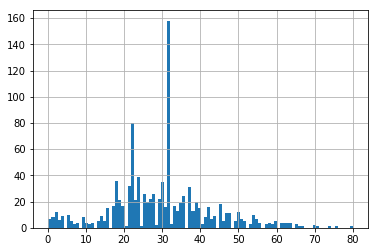

In [9]:
train['age'].hist(bins = 100)

Age must be converted into a categorical variable by sorting the continuous variable into bins. Choosing the most appropriate bins requires some data exploration to see the correlation of age to survival rate.

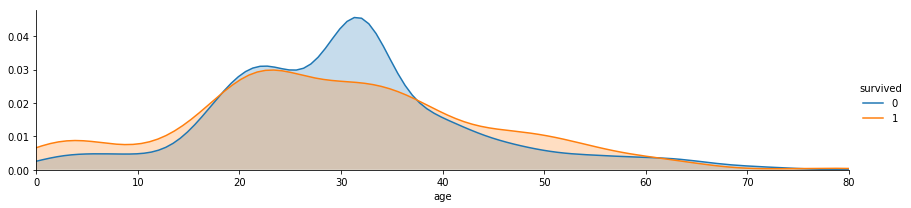

In [10]:
import seaborn as sns
facet = sns.FacetGrid(train, hue="survived",aspect=4)
facet.map(sns.kdeplot,'age',shade= True)
facet.set(xlim=(0, train['age'].max()))
facet.add_legend()

This chart suggests that the survival rate is somewhat higher for children (age < 18) and much lower for adults (age 25-40). For now, I will use five bins for age.

In [11]:
for data_set in all_data:
    data_set.loc[(data_set['age'] >= 0) & (data_set['age'] <= 18), 'age'] = 0 # children
    data_set.loc[(data_set['age'] > 18) & (data_set['age'] <= 25), 'age'] = 1 # young adult
    data_set.loc[(data_set['age'] > 25) & (data_set['age'] <= 40), 'age'] = 2 # adult
    data_set.loc[(data_set['age'] > 40) & (data_set['age'] <= 60), 'age'] = 3 # middle age
    data_set.loc[(data_set['age'] > 60), 'age'] = 4 # seniors
    
    data_set['age'] = data_set['age'].astype(int)

## Fare

The **fare** variable has similar issues as age. First, we must deal with one missing value.

In [12]:
train['fare'].isna().sum()

0

In [13]:
# Compute median fare
fare_value = train['fare'].median()

for data_set in all_data:
    data_set.loc[(data_set['fare'].isna()), 'fare'] = fare_value
  

Fare must also be transformed from a continuous to a categorical variable. The following chart shows a low survival rate for passengers with the lowest fare (< 17) and a generally higher survival rate for higher fares. 

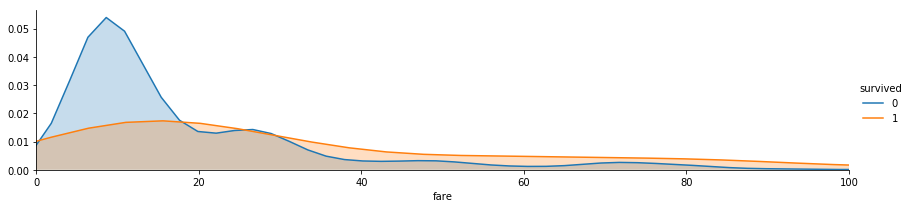

In [14]:
facet = sns.FacetGrid(train, hue="survived",aspect=4)
facet.map(sns.kdeplot,'fare',shade= True)
facet.set(xlim=(0, 100))
facet.add_legend()

In [15]:
for data_set in all_data:
    data_set.loc[(data_set['fare'] >= 0) & (data_set['fare'] <= 18), 'fare'] = 0
    data_set.loc[(data_set['fare'] > 18) & (data_set['fare'] <= 100), 'fare'] = 1
    data_set.loc[(data_set['fare'] > 100), 'fare'] = 2
    data_set['fare'] = data_set['fare'].astype(int)

## Family Size

The variables **parch** (parents + children) and **sibsp** (siblings + spouse) are measures of family size. It is more convenient to combine these into a single feature. 

In [16]:
# Create new feature Family = SibSp + Parch + 1 
for data_set in all_data:
    data_set['family'] = data_set['sibsp'] + data_set['parch'] + 1
    data_set.drop(['sibsp','parch'], axis = 1)

The following chart shows that the survival rate is much lower for individuals than for those with other family members aboard.

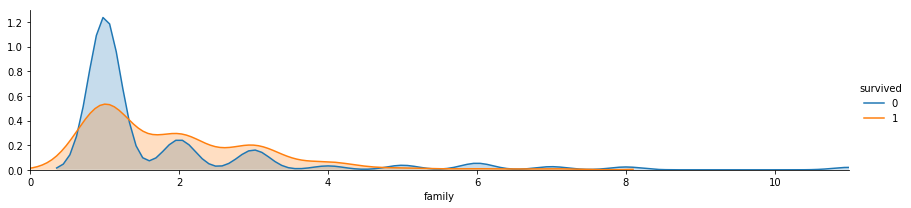

In [17]:
facet = sns.FacetGrid(train, hue="survived",aspect=4)
facet.map(sns.kdeplot,'family',shade= True)
facet.set(xlim=(0, train['family'].max()))
facet.add_legend()

## Location of Embarkment

Finally, the variable **embarked** is another categorical variable that must be encoded numerically. 

In [18]:
for data_set in all_data:
    data_set['embarked'].fillna('S', inplace = True) # replace NA with 'S'
    data_set['embarked'] = data_set['embarked'].map({'S': 0, 'C': 1, 'Q' : 2}).astype(int) 


## Step 4. Drop features that will not be used in the model

Some features will not be used when fitting the model. These will be dropped from the dataframe.

In [19]:
drop_elements = ["name", "title", "ticket", "cabin", "home.dest"]
train = train.drop(drop_elements, axis = 1)
test = test.drop(drop_elements, axis = 1)

The remaining columns are all numerically encoded and ready for the model.

In [20]:
train.head(10)

,pclass,survived,sex,age,sibsp,parch,fare,embarked,family
489,2,1,0,3,1,0,1,0,2
505,2,0,1,3,0,0,0,0,1
964,3,0,1,2,0,0,1,0,1
650,3,0,0,0,0,0,0,1,1
301,1,0,1,3,0,0,1,0,1
317,1,1,1,1,0,1,1,1,2
978,3,1,1,2,0,0,0,0,1
157,1,0,1,2,0,0,1,0,1
725,3,1,0,1,0,0,0,2,1
894,3,1,1,0,1,1,0,0,3


## Step 5. Train the Model

For this problem I will use the DecisionTreeClassifier provided by sklearn. In order to fit the model, we must first separate the observations (y) from the features (x) in the test and train sets. 

In [21]:
x_train = train.drop('survived', axis = 1)
y_train = train['survived']
x_test = test.drop('survived', axis = 1)
y_test = test['survived']

The model is fit to the train data and then used to make predictions based on the test data.

In [22]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()
clf = clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)

## Step 6. Evaluate the Model

We can use the accuracy_score provided by scikit-learn to evaluate the model. Since the target values are binary (1 or 0) we can score accuracy based on the proportion of correct predictions.

In [23]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.7824427480916031